In [1]:
import sys
sys.path.append("../")
from udl_2024_package.nn import unet_factory
from udl_2024_package.vincent_diffusion import DiffusionModel

In [2]:
model = DiffusionModel.load_from_checkpoint("experiment_00_pure_diffusion_models/cifar10_eternal-glitter-1_epochepoch=4.ckpt", model=unet_factory(32, 3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04271084..0.5223283].


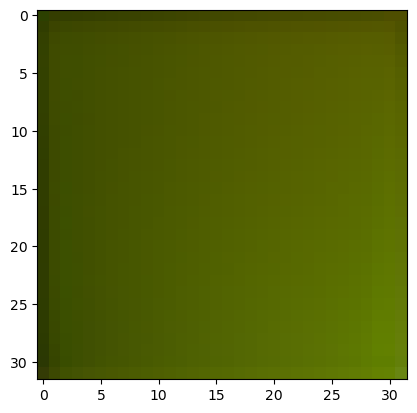

In [3]:
import matplotlib.pyplot as plt
import torch

model.eval()

with torch.no_grad():
    samples = model.sample_img((4, 3, 32, 32))
plt.imshow(samples[0].transpose(0, 2).detach().cpu() * 0.5 + 0.5)

In [6]:
from torchvision import datasets
from torch.utils.data import DataLoader
from udl_2024_package.datasets import remove_dataset_labels, default_img_transforms

In [7]:
# WandB config:
project_name = "udl_2025_diffusion_gan"
group_name = "experiment_00_pure_diffusion"

config = {
    # Input data and training:
    "batch_size": 32,
    "dataset_cls": datasets.CIFAR10,
        "ds_name": "cifar10",   # Warning: change when changing dataset
        "num_channels": 3,      # Warning: change when changing dataset
        "img_size": 32,         # Warning: change when changing dataset
    "max_epochs": 150,
    "dl_num_workers": 4,
}

# TODO: change this to the local memory of the model once I run it on Habrok
datasets_path = "./datasets"

dataloader_kwargs = {
    "batch_size": config["batch_size"],
    "shuffle": True,
    "num_workers": config["dl_num_workers"],
    "pin_memory": True,
}

In [8]:
ds_transforms = default_img_transforms(config["num_channels"])

train_ds = config["dataset_cls"](datasets_path, transform=ds_transforms, download=True, train=True)
val_ds   = config["dataset_cls"](datasets_path, transform=ds_transforms, download=True, train=False)

train_ds = remove_dataset_labels(train_ds)
val_ds   = remove_dataset_labels(val_ds)

train_dl = DataLoader(train_ds, **dataloader_kwargs)
val_dl   = DataLoader(val_ds, **dataloader_kwargs)

In [9]:
batch = next(iter(train_dl))[:4]
batch.shape

torch.Size([4, 3, 32, 32])

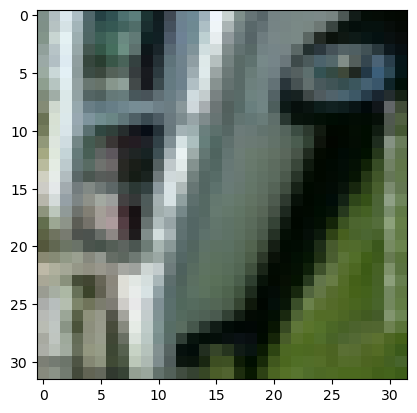

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3126049..1.12403].


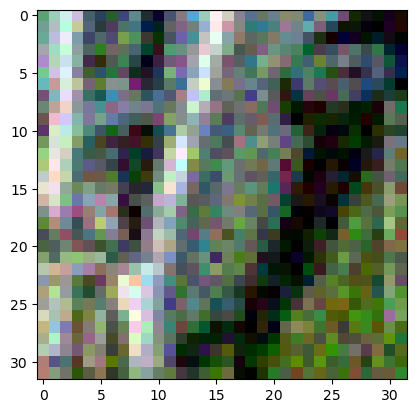

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.023461282..0.9650441].


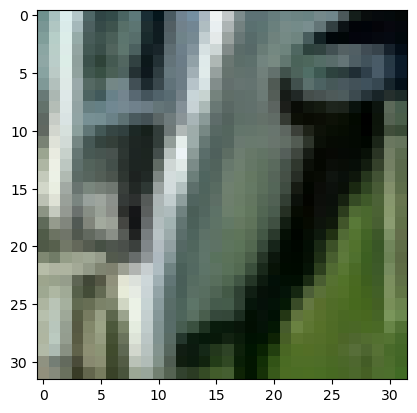

In [26]:
model.to("cpu")

idx = 3
t = 50

with torch.no_grad():
    noised = model.noiser.closed_form_noise(batch, torch.randn_like(batch), torch.full((4,), t, device=batch.device))


plt.imshow(batch[idx].detach().cpu().transpose(0,2) * 0.5 + 0.5)
plt.show()

plt.imshow(noised[idx].detach().cpu().transpose(0,2) * 0.5 + 0.5)
plt.show()

with torch.no_grad():
    predicted_noise = model(noised, t)
    reconstruction = model.noiser.img_from_closed_form_noise(noised, predicted_noise, torch.full((4,), t, device=batch.device))

plt.imshow(reconstruction[idx].detach().cpu().transpose(0,2) * 0.5 + 0.5)
plt.show()

# Discriminator Architecture

In [2]:
import torch
from torch import nn
from torchvision import models

In [20]:
dummy_batch = torch.randn((4,3,32,32))

class CustomResNetBlock(nn.Module):

    def __init__(self, in_channels: int, out_channels: int, downsample: bool, kernel_size: int = 3):
        super(CustomResNetBlock, self).__init__()
        self.downsample = downsample
        
        self.skip_conv = None
        if in_channels != out_channels:
            self.skip_conv = nn.Conv2d(in_channels, out_channels, 1)
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding='same')
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding='same')
    
    def forward(self, x):
        skip = nn.functional.avg_pool2d(x, 2) if self.downsample else x
        if self.skip_conv is not None:
            skip = self.skip_conv(skip)
        
        x = self.conv1(x)
        # TODO: maybe batchnorm
        x = nn.functional.relu(x)

        x = self.conv2(x)
        # TODO: maybe batchnorm
        x = nn.functional.relu(x)

        if self.downsample:
            x = nn.functional.avg_pool2d(x, 2)

        return x + skip

In [28]:
class SimpleDiscriminator(nn.Module):

    def __init__(self,
                 in_channels: int = 3,
                 channel_list: list[int] = [128] * 4,
                 kernel_list: list[int] = [3] * 4,
                 downsample_list: list[bool] = [True] * 2 + [False] * 2
        ):
        super(SimpleDiscriminator, self).__init__()

        resnet_layers = []
        for ch, k, ds in zip(channel_list, kernel_list, downsample_list):
            resnet_layers.append(CustomResNetBlock(in_channels, ch, ds, k))
            in_channels = ch
        self.resnet_layers = nn.Sequential(*resnet_layers)

        self.out = nn.Linear(in_channels, 1)
    
    def forward(self, x):
        x = self.resnet_layers(x)
        x = x.view(*x.shape[:2], -1).mean(-1, False)
        x = self.out(x)
        return x

discriminator = SimpleDiscriminator(3)
discriminator(dummy_batch).shape

torch.Size([4, 1])

In [29]:
import sys
sys.path.append("../../")
from udl_2024_package.nn import discriminator_factory

model = discriminator_factory(3)
model(dummy_batch).shape

torch.Size([4, 1])

In [31]:
print(f"{sum(p.numel() for p in model.parameters() if p.requires_grad):_}")

21_285_185
